# Earning Binary Classification Prediction

Data source: https://archive.ics.uci.edu/dataset/2/adult

In [ ]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import optuna

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
pip install ucimlrepo

DEPRECATION: Loading egg at /Applications/anaconda3/lib/python3.11/site-packages/autofolio-2.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
Note: you may need to restart the kernel to use updated packages.


In [3]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [4]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [5]:
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


## EDA

In [6]:
#create age bucket and hours per week bucket
def create_age_bucket(df):
    """
    Function to create age bucket
    """
    bins = [0, 18, 25, 35, 45, 55, 65, 100]
    labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
    df['age_bucket'] = pd.cut(df['age'], bins=bins, labels=labels)
    return df

def create_hours_per_week_bucket(df):
    """
    Function to create hours per week bucket
    """
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
    labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
    df['hours_per_week_bucket'] = pd.cut(df['hours-per-week'], bins=bins, labels=labels)
    return df

create_age_bucket(X)
create_hours_per_week_bucket(X)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age_bucket,hours_per_week_bucket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,36-45,31-40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,46-55,0-20
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,36-45,31-40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,46-55,31-40
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,26-35,31-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,36-45,31-40
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,56-65,31-40
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,36-45,41-50
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,36-45,31-40


In [7]:
def cat_num_col(df):
    """
    Function to separate categorical and numerical columns
    """
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
    
    return cat_cols, num_cols

cat_col, num_col = cat_num_col(X)

print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)


Categorical columns:  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical columns:  ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'age_bucket', 'hours_per_week_bucket']


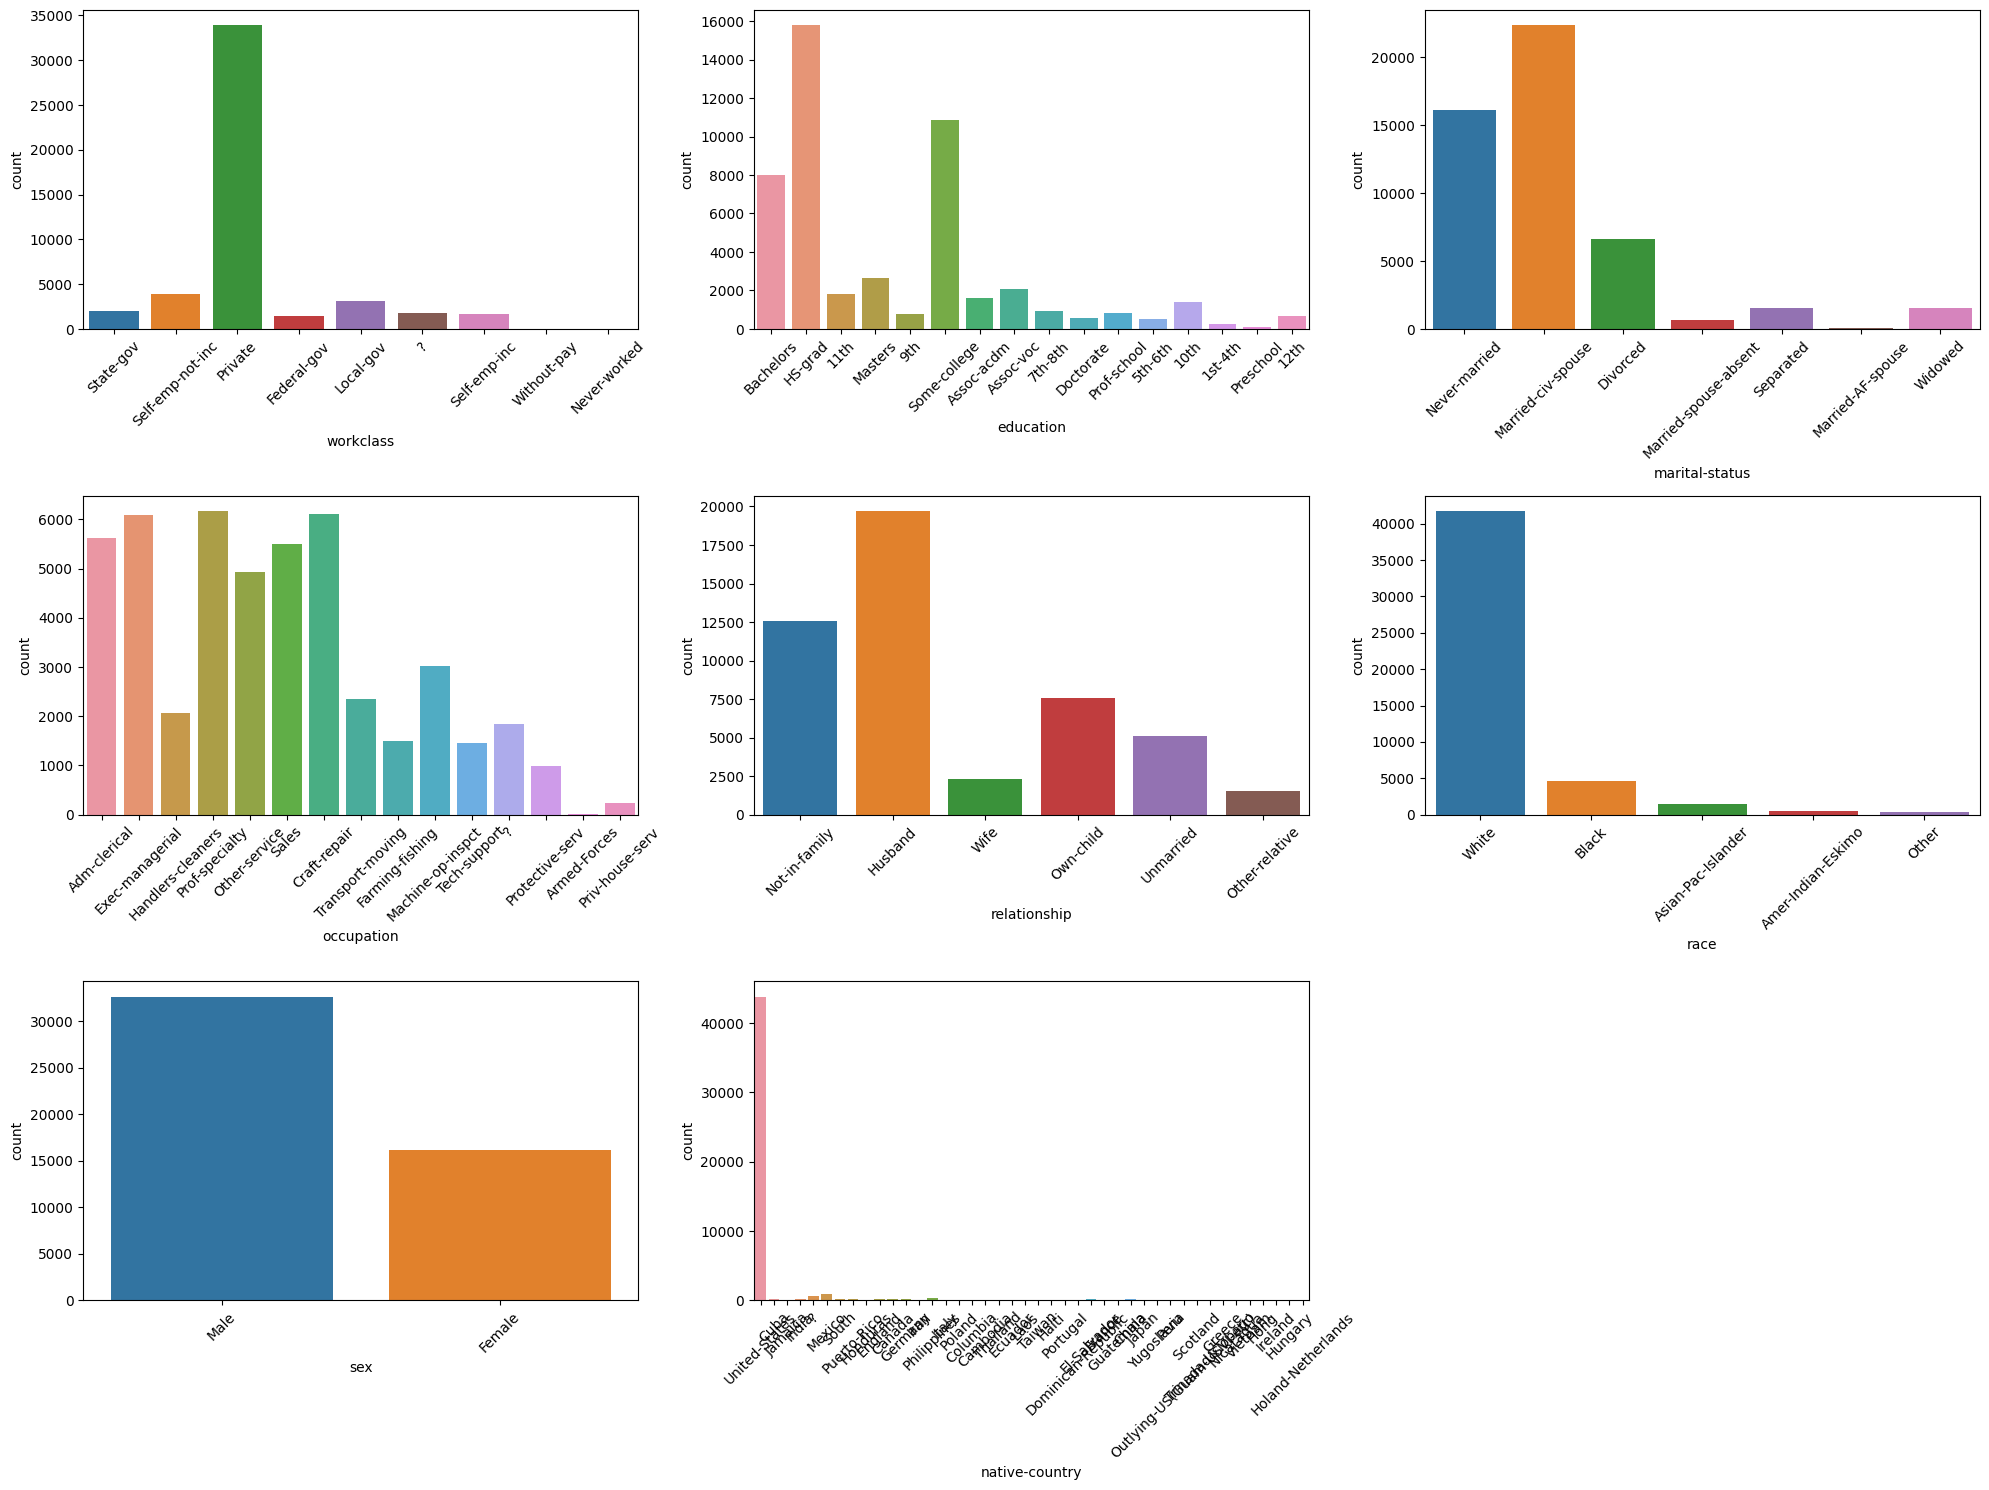

In [8]:
# Calculate the number of rows required in the subplot grid
cnum_cols = len(cat_col)
cnum_rows = cnum_cols // 3 + (cnum_cols % 3 > 0)

# Create the subplot grid
fig, axes = plt.subplots(nrows=cnum_rows, ncols=3, figsize=(20, 5 * cnum_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Create bar plots for each categorical column
for i, col in enumerate(cat_col):
    sns.countplot(x=X[col], ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Private workers are more than all the other work class workers added together 
* High school grads, college, and Bachelors are the most popular education level
* The ethnicity of this dataset isn't well diversified, as more than 60% of the individuals are of white race and most likely were born in the US

In [9]:
# list distinct education and its respective education num
distinct_education = X[['education', 'education-num']].drop_duplicates()
distinct_education = distinct_education.sort_values(by='education-num')

distinct_education

,education,education-num
224,Preschool,1
160,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
77,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


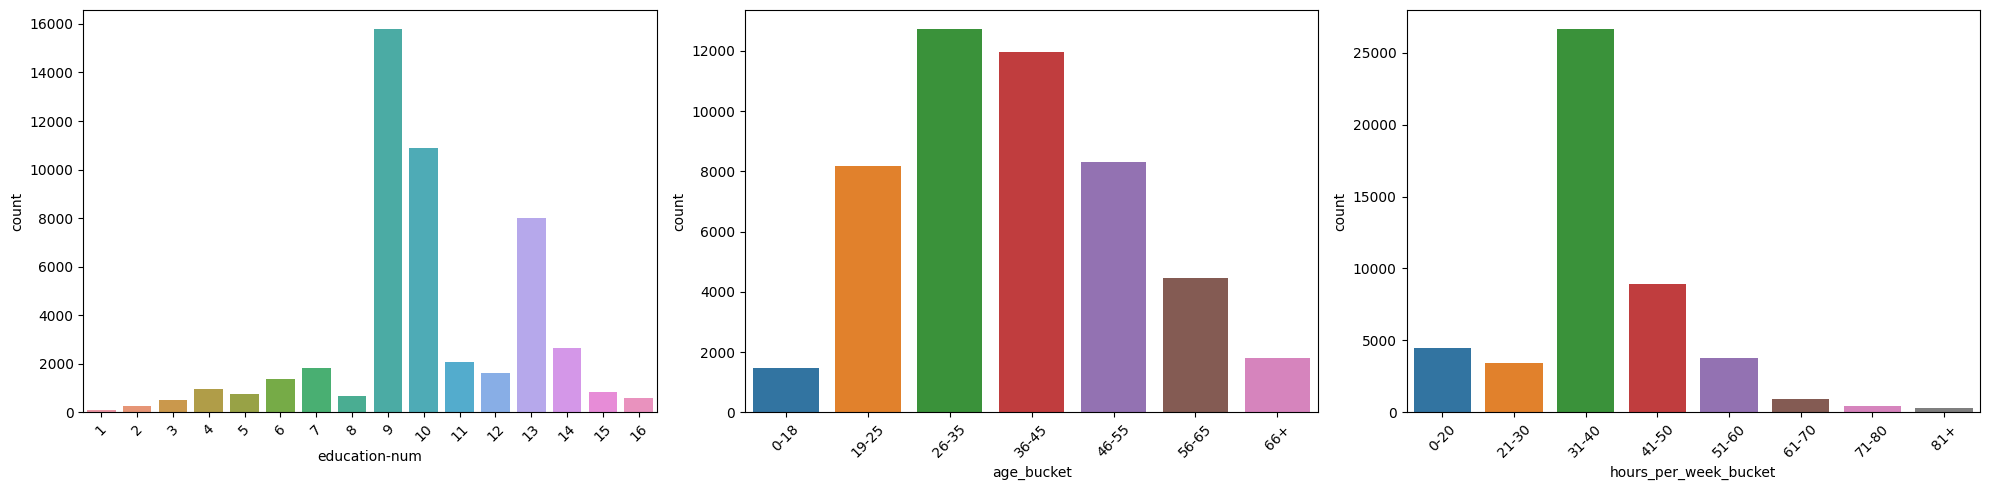

In [10]:
# Calculate the number of rows required in the subplot grid
exclude_cols = ['fnlwgt', 'age', 'hours-per-week', 'capital-gain', 'capital-loss']
num_col = [col for col in num_col if col not in exclude_cols]
cnum_cols = len(num_col)
cnum_rows = cnum_cols // 3 + (cnum_cols % 3 > 0)

# Create the subplot grid
fig, axes = plt.subplots(nrows=cnum_rows, ncols=3, figsize=(20, 5 * cnum_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Create bar plots for each categorical column
for i, col in enumerate(num_col):
    sns.countplot(x=X[col], ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* The education level overall is medium-high, with majority of people having completed a high school degree or college diploma
* Age is evenly distributed
* Most people work full-time, as 31-40 hours and above is the most frequent working hours per week

In [11]:
# Look at min max average of capital gain and loss
print("Capital Gain: ")
print(X['capital-gain'].describe())
print("\nCapital Loss: ")
print(X['capital-loss'].describe())


Capital Gain: 
count    48842.000000
mean      1079.067626
std       7452.019058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

Capital Loss: 
count    48842.000000
mean        87.502314
std        403.004552
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64


In [12]:
# count capital loss and gain that is non-zero
capital_gain_non_zero = X[X['capital-gain'] > 0].shape[0]
capital_loss_non_zero = X[X['capital-loss'] > 0].shape[0]
print(f"Number of rows with non-zero capital gain: {capital_gain_non_zero}")
print(f"Number of rows with non-zero capital loss: {capital_loss_non_zero}")

Number of rows with non-zero capital gain: 4035
Number of rows with non-zero capital loss: 2282


In [13]:
(4035 + 2282)/len(X) * 100

12.933540805044839

* Less than 13% of people had a capital loss or gain in this dataset
* The highest loss is $4,356 and the highest gain is $99,999

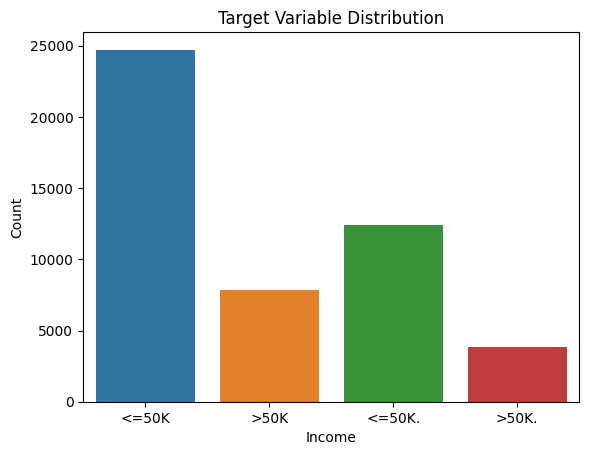

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64


In [14]:
# Plot y variable
sns.countplot(x=y['income'])
plt.title('Target Variable Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

distiinct_income = y['income'].value_counts()
print(distiinct_income)

In [15]:
# Add back excluded columns to num_col
num_col = num_col + exclude_cols

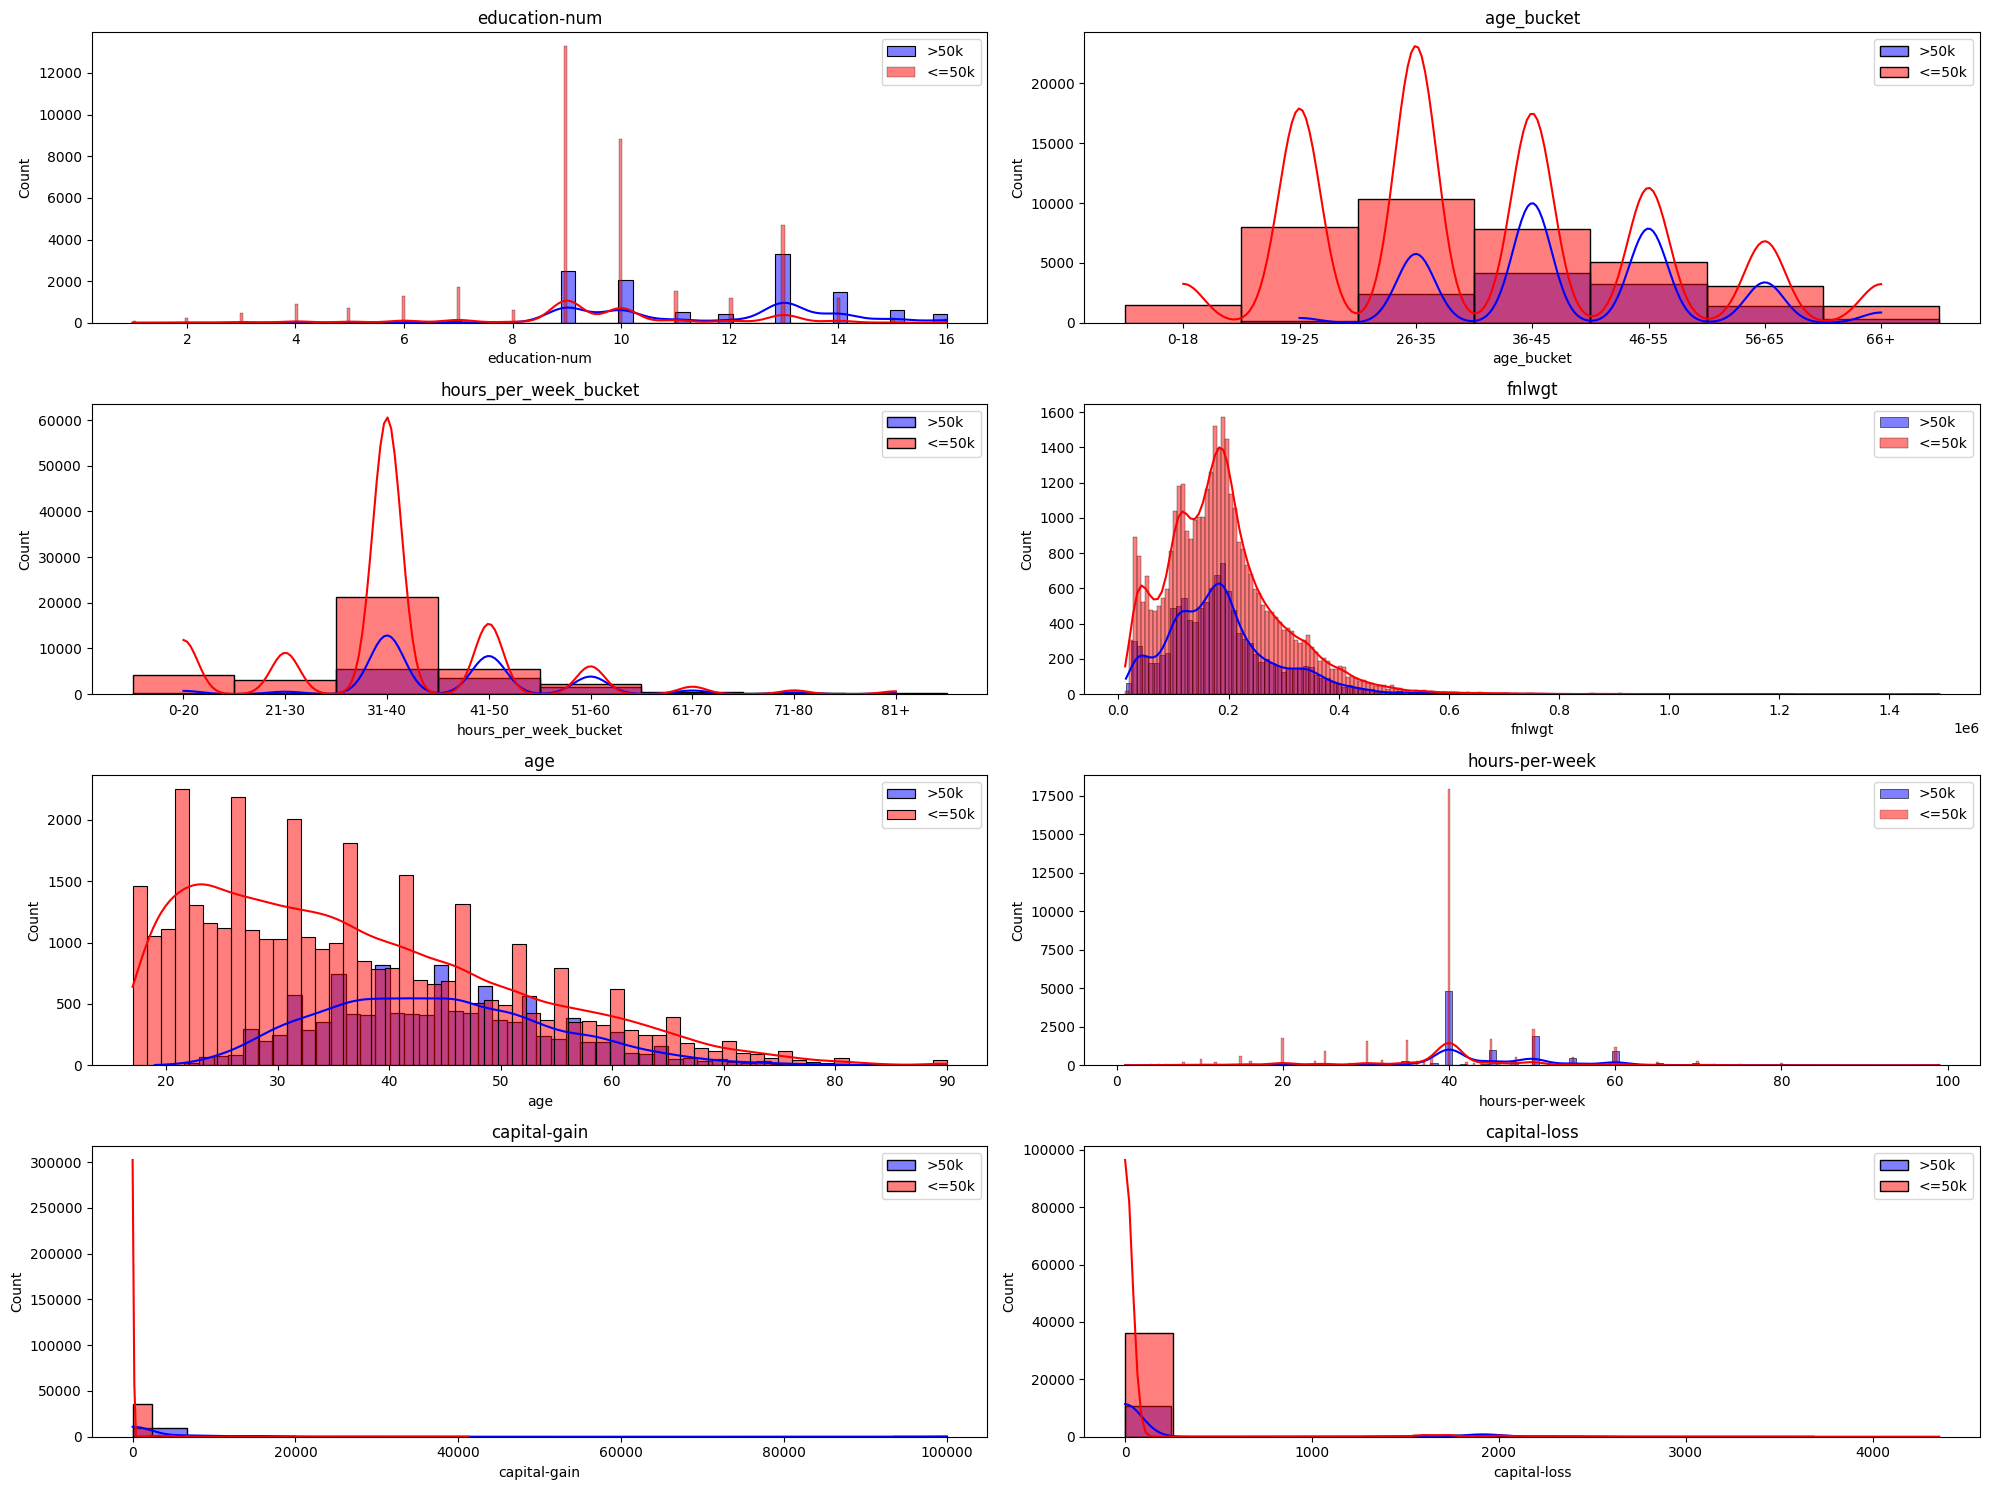

In [16]:
sns.set_palette("deep")

plt.figure(figsize=(20, cnum_cols * 5))  # Adjust the figure size based on the number of rows

# Adjust the number of subplots based on the number of numerical columns you have
num_plots = len(num_col)
num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1

for i, feature in enumerate(num_col):
    plt.subplot(num_rows, 2, i + 1)  # Adjust for the appropriate number of rows and columns

    # Filter the data for the histogram
    sns.histplot(data=X[(y['income'] == '>50K') | (y['income'] == '>50K.')], x=feature, kde=True, color="blue", label='>50k')
    sns.histplot(data=X[(y['income'] == '<=50K') | (y['income'] == '<=50K.')], x=feature, kde=True, color="red", label='<=50k')
    
    plt.legend()  # Show the legend
    plt.title(feature)  # Set the title to the feature name

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

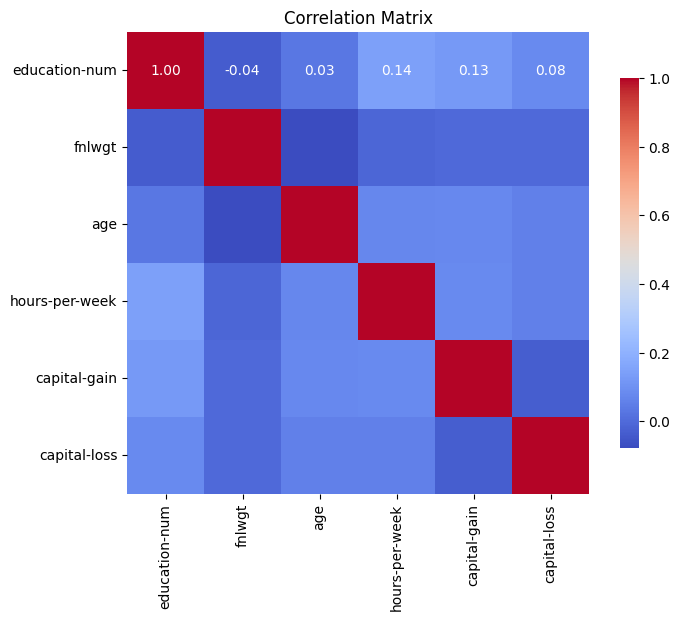

In [17]:
# Data collinearity
buckets = ['age_bucket', 'hours_per_week_bucket']
num_col = [col for col in num_col if col not in buckets]

# Calculate the correlation matrix
correlation_matrix = X[num_col].corr()
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


* There is no multicollinearity

## Preprocessing

* Native country should be dropped, as it's almost unary
* Education can be dropped, as there's the education-num column in ordinal sequence already
* Target y needs to be binary, group <=50K and <=50K., >50K and  >50K.

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

In [19]:
# Make adult a dataframe
adult_df = adult.data.features
# Join the target variable
adult_df = adult_df.join(adult.data.targets)
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age_bucket,hours_per_week_bucket,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,36-45,31-40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,46-55,0-20,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,36-45,31-40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,46-55,31-40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,26-35,31-40,<=50K


In [20]:
# Find missing values in adult_df
missing_values = adult_df.isnull().sum()
missing_values[missing_values > 0]


workclass         963
occupation        966
native-country    274
dtype: int64

In [21]:
# Find duplicates in adult_df
duplicates = adult_df.duplicated().sum()
duplicates

29

In [22]:
def preprocess_data(df):
    
    # Drop unnecessary columns
    df = df.drop(columns=['native-country', 'education', 'age_bucket', 'hours_per_week_bucket'])
    
    # Convert target variable
    df['income'] = df['income'].replace({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})
    
    # Separate features (X) and target (y)
    y = df['income']
    X = df.drop(columns=['income'])

    # Handle missing values in workclass and occupation by using the mode
    X['workclass'] = X['workclass'].fillna(X['workclass'].mode()[0])
    X['occupation'] = X['occupation'].fillna(X['occupation'].mode()[0])
    
    # Frequency encoding for categorical columns
    freq_cols = ['workclass', 'occupation', 'race', 'relationship']
    for col in freq_cols:
        freq_map = X[col].value_counts(normalize=True).to_dict()  # Get frequency as a dictionary
        X[col] = X[col].map(freq_map)  # Replace categories with frequencies

    # One hot encoding for marital status
    marital_status_dummies = pd.get_dummies(X['marital-status'], prefix='marital', drop_first=True)
    X = pd.concat([X, marital_status_dummies], axis=1)
    X = X.drop(columns=['marital-status'])  # Drop original column

    # Label encoding for sex (Male=1, Female=0)
    X['sex'] = LabelEncoder().fit_transform(X['sex'])

    # Normalize numerical variables (excluding one-hot and label encoded)
    numerical_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'occupation', 'race', 'relationship', 'education-num']
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Combine features and target
    df = pd.concat([X, y], axis=1)
    
    return df

preprocessed_df = preprocess_data(adult_df)
preprocessed_df.head()

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,marital_Married-AF-spouse,marital_Married-civ-spouse,marital_Married-spouse-absent,marital_Never-married,marital_Separated,marital_Widowed,income
0,0.025996,-1.624376,-1.061979,1.136512,0.380504,-0.078580,0.411262,1,0.146932,-0.217127,-0.034087,False,False,False,True,False,False,0
1,0.828308,-1.495287,-1.007104,1.136512,0.632811,1.066286,0.411262,1,-0.144804,-0.217127,-2.213032,False,True,False,False,False,False,0
2,-0.046942,0.632653,0.246034,-0.419335,-1.499319,-0.078580,0.411262,1,-0.144804,-0.217127,-0.034087,False,False,False,False,False,False,0
3,1.047121,0.632653,0.426663,-1.197259,-1.499319,1.066286,-2.336603,1,-0.144804,-0.217127,-0.034087,False,True,False,False,False,False,0
4,-0.776316,0.632653,1.408530,1.136512,1.191606,-1.724054,-2.336603,0,-0.144804,-0.217127,-0.034087,False,True,False,False,False,False,0


In [23]:
# Find missing values in adult_df
missing_values = preprocessed_df.isnull().sum()
if missing_values[missing_values > 0].any():
    print(missing_values[missing_values > 0])
else:
    print("No missing values")


No missing values


# Models

In [24]:

# Split data into train (60%), validation (20%), and test (20%)
X = preprocessed_df.drop(columns=['income'])
y = preprocessed_df['income']

# First split: Train + Temp vs. Test (80% vs 20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Second split: Train vs. Validation (75% of 80% → 60% train, 25% of 80% → 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, 
    test_size=0.25,  # 25% of the remaining 80% → 20% of total data
    stratify=y_train_temp, 
    random_state=42
)

# Verify sizes
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Train: 29304 samples
Validation: 9769 samples
Test: 9769 samples


In [25]:
# Create model results df
model_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

def evaluate_model(model_name, y_true, y_pred, y_proba=None, results_df=model_results):

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba) if y_proba is not None else None
    }

    new_result = pd.DataFrame([metrics])
    if results_df is not None:
        results_df = pd.concat([results_df, new_result], ignore_index=True)
    else:
        results_df = new_result

    return results_df


### Model Metrics Definitions

 **Accuracy**  
The proportion of total predictions that are correct.  
It measures how often the model gets both positive and negative predictions right.


 **Precision**  
The proportion of positive predictions that were actually correct.  
It tells you how many of the predicted positives were true positives.

 **Recall** (Sensitivity or True Positive Rate)  
The proportion of actual positives that were correctly identified.  
It shows how well the model captures all true positives.


 **F1-Score**  
The harmonic mean of precision and recall — balances the two.  
Useful when you want to balance false positives and false negatives.


 **ROC AUC** (Receiver Operating Characteristic — Area Under the Curve)  
Measures the model's ability to distinguish between classes at all thresholds.  
- AUC = 1 means perfect separation  
- AUC = 0.5 means no better than random guessing  


## Random Forest

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
# Initialize the model
rf_model = RandomForestClassifier(random_state=42)
# Fit the model
rf_model.fit(X_train, y_train)
# Make predictions
y_val_pred_rf = rf_model.predict(X_val)

# Calculate metrics
model_results = evaluate_model("Random Forest", y_val, y_val_pred_rf, y_proba=rf_model.predict_proba(X_val)[:, 1], results_df=model_results)
model_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.85843,0.737313,0.634146,0.68185,0.907616


## Light GBM

In [27]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

from lightgbm import early_stopping

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Use validation set for early stopping
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Evaluate on val set
y_val_pred_lgb = lgb_model.predict(X_val)

# Evaluate the model and update the results DataFrame
model_results = evaluate_model("LightGBM", y_val, y_val_pred_lgb, y_proba=lgb_model.predict_proba(X_val)[:, 1], results_df=model_results)
model_results


[LightGBM] [Info] Number of positive: 7012, number of negative: 22292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 29304, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's auc: 0.929833	valid_0's binary_logloss: 0.330226


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,LightGBM,0.836626,0.610762,0.874198,0.719113,0.929833


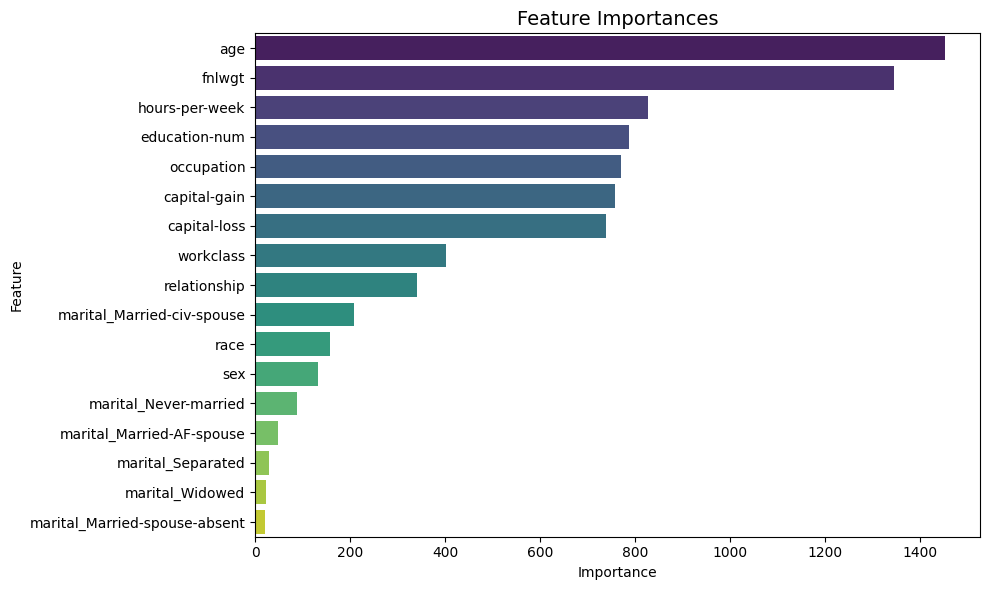

In [28]:
importances = lgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Feature Importances", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## XGBoost

In [29]:
# Train XGBoost
from xgboost import XGBClassifier
# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)
# Fit the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Use validation set for early stopping
    eval_metric='auc',
    early_stopping_rounds=50
)
# Evaluate on val set
y_val_pred_xgb = xgb_model.predict(X_val)


model_results = evaluate_model("XGBoost", y_val, y_val_pred_xgb, y_proba=xgb_model.predict_proba(X_val)[:, 1], results_df=model_results)

model_results

[0]	validation_0-auc:0.89224
[1]	validation_0-auc:0.89630
[2]	validation_0-auc:0.89834
[3]	validation_0-auc:0.90119
[4]	validation_0-auc:0.90214
[5]	validation_0-auc:0.90278
[6]	validation_0-auc:0.90392
[7]	validation_0-auc:0.90443
[8]	validation_0-auc:0.90525
[9]	validation_0-auc:0.90532
[10]	validation_0-auc:0.90553
[11]	validation_0-auc:0.90664
[12]	validation_0-auc:0.90671
[13]	validation_0-auc:0.90695
[14]	validation_0-auc:0.90742


/Applications/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.90801
[16]	validation_0-auc:0.90850
[17]	validation_0-auc:0.90873
[18]	validation_0-auc:0.90909
[19]	validation_0-auc:0.90918
[20]	validation_0-auc:0.90994
[21]	validation_0-auc:0.91020
[22]	validation_0-auc:0.91065
[23]	validation_0-auc:0.91093
[24]	validation_0-auc:0.91110
[25]	validation_0-auc:0.91142
[26]	validation_0-auc:0.91174
[27]	validation_0-auc:0.91199
[28]	validation_0-auc:0.91235
[29]	validation_0-auc:0.91251
[30]	validation_0-auc:0.91278
[31]	validation_0-auc:0.91326
[32]	validation_0-auc:0.91337
[33]	validation_0-auc:0.91352
[34]	validation_0-auc:0.91369
[35]	validation_0-auc:0.91401
[36]	validation_0-auc:0.91426
[37]	validation_0-auc:0.91438
[38]	validation_0-auc:0.91444
[39]	validation_0-auc:0.91456
[40]	validation_0-auc:0.91476
[41]	validation_0-auc:0.91487
[42]	validation_0-auc:0.91516
[43]	validation_0-auc:0.91536
[44]	validation_0-auc:0.91554
[45]	validation_0-auc:0.91576
[46]	validation_0-auc:0.91584
[47]	validation_0-auc:0.91605
[48]	valid

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,LightGBM,0.836626,0.610762,0.874198,0.719113,0.929833
1,XGBoost,0.832736,0.604272,0.871630,0.713735,0.929935


## SVC Classifier


In [30]:
# SVC classifier
from sklearn.svm import SVC
# Initialize the model
svc_model = SVC(
    kernel='linear',  # Linear kernel
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    probability=True  # Needed for ROC AUC
)
# Fit the model
svc_model.fit(X_train, y_train)
# Evaluate on val set
y_val_pred_svc = svc_model.predict(X_val)

model_results = evaluate_model("SVC", y_val, y_val_pred_rf, y_proba=rf_model.predict_proba(X_val)[:, 1], results_df=model_results)

model_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,LightGBM,0.836626,0.610762,0.874198,0.719113,0.929833
1,XGBoost,0.832736,0.604272,0.871630,0.713735,0.929935
2,SVC,0.858430,0.737313,0.634146,0.681850,0.907616


In [ ]:
# Logistic Regression
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_model.fit(X_train, y_train)
y_val_pred_log_reg = log_reg_model.predict(X_val)
model_results = evaluate_model("Logistic Regression", y_val, y_val_pred_log_reg, y_proba=log_reg_model.predict_proba(X_val)[:, 1], results_df=model_results)

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_val_pred_dt = dt_model.predict(X_val)
model_results = evaluate_model("Decision Tree", y_val, y_val_pred_dt, results_df=model_results)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_val_pred_knn = knn_model.predict(X_val)
model_results = evaluate_model("KNN", y_val, y_val_pred_knn, results_df=model_results)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, random_state=42)
gb_model.fit(X_train, y_train)
y_val_pred_gb = gb_model.predict(X_val)
model_results = evaluate_model("Gradient Boosting", y_val, y_val_pred_gb, results_df=model_results)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_val_pred_nb = nb_model.predict(X_val)
model_results = evaluate_model("Naive Bayes", y_val, y_val_pred_nb, results_df=model_results)


In [35]:
# Sort the results by ROC AUC
model_results = model_results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
model_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,XGBoost,0.832736,0.604272,0.871630,0.713735,0.929935
1,LightGBM,0.836626,0.610762,0.874198,0.719113,0.929833
2,SVC,0.858430,0.737313,0.634146,0.681850,0.907616
3,Random Forest,0.858430,0.737313,0.634146,0.681850,0.907616
4,Logistic Regression,0.796806,0.548512,0.851519,0.667225,0.897206
5,Decision Tree,0.815334,0.612400,0.621309,0.616822,NaN
6,KNN,0.829665,0.660010,0.593924,0.625225,NaN
7,Gradient Boosting,0.871942,0.772590,0.658537,0.711019,NaN
8,Naive Bayes,0.797625,0.558632,0.733847,0.634363,NaN


* Gradient Boosting is the most accurate and precise model, meaning that it had the highest percentage of correct predictions
* LightGBM has the highest recall and F1 scores amongst the models
* XGBoost has the best ROC AUC score, meaning that it is best at distinguishing false and positive results

Boosting models are leading the game. Boosting models are powerful because they combine many weak learners sequentially, each focusing on the errors of the previous one, to reduce bias and variance. This creates highly accurate, robust predictions even on complex datasets.

Given that XGBoost has the highest ROC and AUC and that the F1 scores of the models range from ~61-71%, I decided to perform model fine-tuning on XGBoost.

## Model Finetuning

## Grid Search CV

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees
    'learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'max_depth': [3, 5, 7], # Maximum depth of a tree
    'min_child_weight': [1, 3, 5], # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.6, 0.8, 1.0], # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0] # Subsample ratio of columns when constructing each tree
}
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = xgb_grid_search.best_params_
best_score = xgb_grid_search.best_score_
print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)
# Evaluate the best model on the validation set
best_xgb_model = xgb_grid_search.best_estimator_
y_val_pred_best_xgb = best_xgb_model.predict(X_val)
model_results = evaluate_model("Best XGBoost", y_val, y_val_pred_best_xgb, y_proba=best_xgb_model.predict_proba(X_val)[:, 1], results_df=model_results)

# Final model evaluation on test set
y_test_pred_best_xgb = best_xgb_model.predict(X_test)
model_results = evaluate_model("Best XGBoost on Test", y_test, y_test_pred_best_xgb, y_proba=best_xgb_model.predict_proba(X_test)[:, 1], results_df=model_results)



Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best ROC AUC Score: 0.9276021378552678


## Optuna

In [37]:
# Optuna fine tuning for XGBoost

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    return roc_auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
# Get the best parameters and score
best_params_optuna = study.best_params
best_score_optuna = study.best_value
print("Best Parameters from Optuna:", best_params_optuna)
print("Best ROC AUC Score from Optuna:", best_score_optuna)

# Evaluate the best model from Optuna on the validation set
best_xgb_model_optuna = XGBClassifier(**best_params_optuna)
best_xgb_model_optuna.fit(X_train, y_train)
y_val_pred_best_xgb_optuna = best_xgb_model_optuna.predict(X_val)
model_results = evaluate_model("Best XGBoost Optuna", y_val, y_val_pred_best_xgb_optuna, y_proba=best_xgb_model_optuna.predict_proba(X_val)[:, 1], results_df=model_results)
# Final model evaluation on test set
y_test_pred_best_xgb_optuna = best_xgb_model_optuna.predict(X_test)
model_results = evaluate_model("Best XGBoost Optuna on Test", y_test, y_test_pred_best_xgb_optuna, y_proba=best_xgb_model_optuna.predict_proba(X_test)[:, 1], results_df=model_results)


[I 2025-07-02 10:19:21,342] A new study created in memory with name: no-name-d9923eef-c034-4067-802e-82aff10e8197
[I 2025-07-02 10:19:24,641] Trial 0 finished with value: 0.8431977241207458 and parameters: {'n_estimators': 500, 'learning_rate': 0.09999999999999999, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.8431977241207458.
[I 2025-07-02 10:19:26,875] Trial 1 finished with value: 0.84391229014409 and parameters: {'n_estimators': 350, 'learning_rate': 0.09999999999999999, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.84391229014409.
[I 2025-07-02 10:19:27,261] Trial 2 finished with value: 0.8105781968178869 and parameters: {'n_estimators': 100, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.84391229014409.
[I 2025-07-02 10:19:30,909] Trial 3 finished with value: 0

Best Parameters from Optuna: {'n_estimators': 200, 'learning_rate': 0.06999999999999999, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.8}
Best ROC AUC Score from Optuna: 0.8484081949340259


* Hyperparameter tuning with GridSearch did not improve ROC and AUC. Optuna did not improve the model performance either.
* Therefore, the best model is XGBoost Classifier, having an accuracy of 83%, precision of 60%, recall of 87%, F1 score of 73%, and ROC AUC of 93%